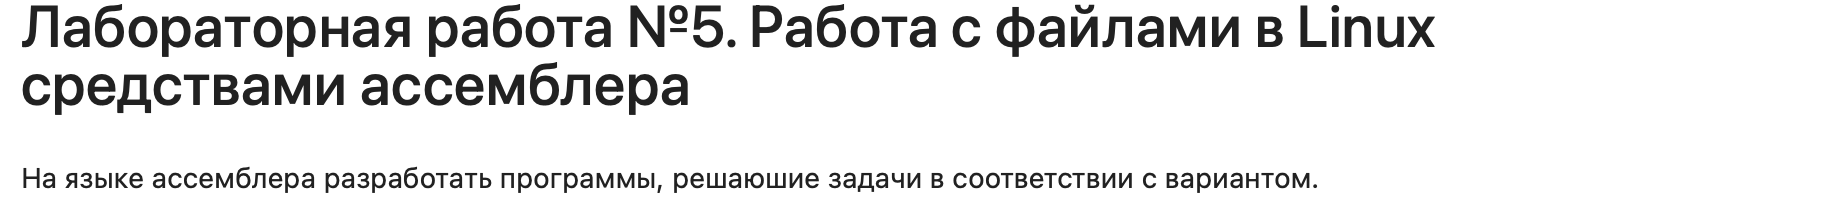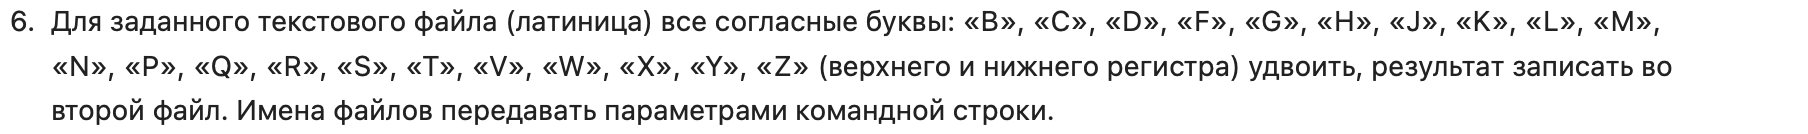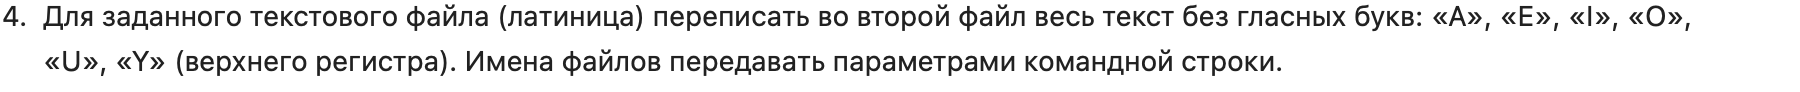

## Assemler code test
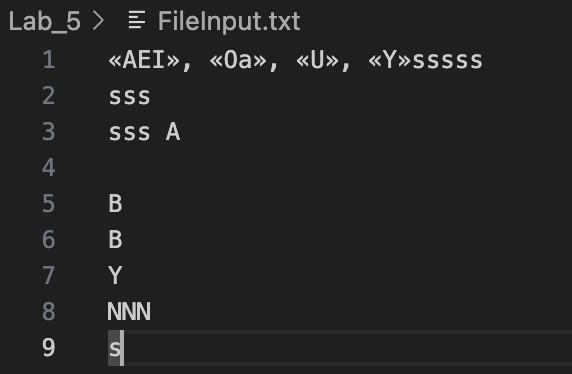
### Problem number 4
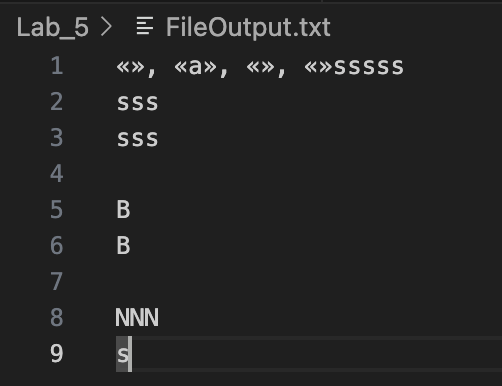

### Problem number 6
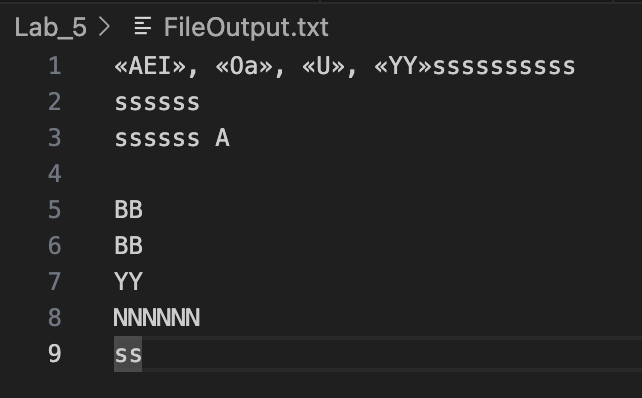

## Assembler code

```ASM
format ELF64

public _start

macro cout _data, _length {
    push rax
    push rbx
    push rdx
    push rsi
        mov rax, 1
        mov rbx, 1
        mov rsi, _data
        mov rdx, _length
        syscall
    pop rsi
    pop rdx
    pop rbx
    pop rax
}

macro cin _bufferInput, _length {
    push rbx
    push rdx
    push rsi
    push rdi
        mov rax, 0
        mov rbx, 0
        mov rsi, _bufferInput
        mov rdx, _length
        syscall

        cmp rax, rdx
        jb .inputNormal

        .flush:
            mov rax, 0
            mov rbx, 0
            mov rsi, _bufferInput       ; временный буфер
            mov rdx, 1                  ; читаем по 1 символу
            syscall
            
            cmp rax, 1
            jne .flushed
            cmp byte [rsi], 10          ; дошли до '\n'
            jne .flush

        .flushed:
            mov rax, -1
            jmp invalidLengthInput

        .inputNormal:
            dec rax
            mov rdi, _bufferInput
            add rdi, rax
            mov byte [rdi], 0
    pop rdi
    pop rsi
    pop rdx
    pop rbx
}

section '.function' executable
    ; input - address char rax
    ; output - int rcx
    CastCharInt:
        push rbx
        push rdi
            ; check a minus
            xor rbx, rbx
            cmp byte [rax], '-'
            sete bl ; if equal bl = 1, else bl = 0

            ; skip a minus
            cmp bl, 1
            jne .startConvert
            inc rax

            .startConvert:
                xor rcx, rcx
            .cycleConvert:
                movzx rdi, byte [rax]
                add rcx, rdi
                sub rcx, '0'
                inc rax

                cmp byte [rax], 0
                je .cycleConvertEnd

                imul rcx, 10
                jmp .cycleConvert
            .cycleConvertEnd:

            cmp bl, 1
            jne .return

            imul rcx, -1

            .return:
        pop rdi
        pop rbx
        ret
    
    ; input - int rax
    ; output - bufferOutput
    CastIntChar:
    push rcx
    push rdi
    push rdx
    push rbx
    push rsi
        ; check a sign
        xor rbx, rbx
        cmp rax, 0
        jge .positive
        
        ; negative
        mov rbx, 1              ; negative flag
        neg rax                 ; make positive
    
        .positive:
            ; find number length
            push rax
            push rbx            ; save sign flag
                mov rcx, 0
                mov rsi, 10
                
                test rax, rax   ; if zero number
                jnz .cycleIntLen
                mov rcx, 1      ; size 1 for zero number
                jmp .CycleDone
                
                .cycleIntLen:
                    xor rdx, rdx
                    div rsi
                    inc rcx
                    test rax, rax
                    jnz .cycleIntLen
                .CycleDone:
            pop rbx             ; restore sign flag
            pop rax
            
            ; consider sign in size
            test rbx, rbx
            jz .unsign
            inc rcx
            
        .unsign:
            push rbx            ; save sign flag
                mov rsi, 10
                mov rdi, bufferOutput
                add rdi, rcx
                mov byte [rdi], 0
                dec rdi
                
                .cycleConverter:
                    xor rdx, rdx
                    div rsi
                    add dl, '0'
                    mov byte [rdi], dl
                    dec rdi
                    test rax, rax
                    jnz .cycleConverter
            .conversionDone:
            pop rbx
            
            ; add sign
            test rbx, rbx
            jz .return
            mov byte [rdi], '-'
            
        .return:
            mov qword [lengthOutput], rcx
    pop rsi
    pop rbx
    pop rdx
    pop rdi
    pop rcx
    ret

section '.data' writeable
    messageOptionProgram:
        db 'Choose one program:', 10
        db '1 - for a given text file (Latin), rewrite the entire text without vowels:', 10
        db '    "A", "E", "I", "O", "U", "Y" (uppercase) into a second file', 10
        db '2 - For a given text file (Latin), double all the consonants:', 10
        db '    "B", "C", "D", "F", "G", "H", "J", "K", "L", "M", "N",', 10
        db '    "Q", "R", "S", "T", "V", "W", "X", "Y", "Z", "P" (uppercase and lowercase)', 10
        db '    and write the result to a second file', 10, 10
        db 'q / Q - quite the programm', 10
    messageOptionEnd:
    kLengthMessageOptionProgram equ messageOptionEnd - messageOptionProgram

    messageInstruction:
        db 'Write positive number (input length 255 digits):', 10
    messageInstructionEnd:
    kLengthMessageInstruction = messageInstructionEnd - messageInstruction

    messageInvalidNumberArgument:
        db 0x1B, '[H', 0x1B, '[J'
        db 'Error: write 2 additional arguments', 10, 10
    messageInvalidNumberArgumentEnd:
    kLengthInvalidNumberArgument equ messageInvalidNumberArgumentEnd - messageInvalidNumberArgument
    
    messageInvalidOption:
        db 0x1B, '[H', 0x1B, '[J'
        db 'Error: choose option between 1 and 2', 10, 10
    messageInvalidOptionEnd:
    kLengthMessageInvalidOption equ messageInvalidOptionEnd - messageInvalidOption

    messageInvalidLengthInput:
        db 0x1B, '[H', 0x1B, '[J'
        db 'Error: input length must be 255 digits', 10, 10
    messageInvalidLengthInputEnd:
    kLengthMessageInvalidLengthInput equ messageInvalidLengthInputEnd - messageInvalidLengthInput

    messageInvalidFileOperation:
        db 0x1B, '[H', 0x1B, '[J'
        db 'Error: working with file', 10, 10
    messageInvalidFileOperationEnd:
    kLengthMessageInvalidFileOperation equ messageInvalidFileOperationEnd - messageInvalidFileOperation

    forbiddenChar db 'AEIOUY'
    kLengthForbiddenChar equ 6

    lovelyChar db 'BCDFGHJKLMNPQRSTVWXYZ'
    kLengthLovelyChar equ 21

    terminalClear db 0x1B, '[H', 0x1B, '[J'
    newLine db 10

    lengthInput dq 0
    lengthOutput dq 0

section '.bss' writeable
    bufferInput rb 256
    bufferOutput rb 256
    fileInput rb 8
    fileOutput rb 8
    fileDiscriptorInput rb 8
    fileDiscriptorOutput rb 8

section '.error' executable
    invalidFileOperation:
        cout messageInvalidFileOperation, kLengthMessageInvalidFileOperation
        jmp closeFiles

    invalidNumberArgument:
        cout messageInvalidNumberArgument, kLengthInvalidNumberArgument
        jmp return

    invalidOption:
        cout messageInvalidOption, kLengthMessageInvalidOption
        jmp main

    invalidLengthInput:
        cout messageInvalidLengthInput, kLengthMessageInvalidLengthInput
        jmp main

section '.text' executable    
_start:
    cout terminalClear, 6

    pop rax
    cmp rax, 3
    jne invalidNumberArgument

    pop rax
    pop rax
    mov qword [fileInput], rax

    pop rax
    mov qword [fileOutput], rax

main:
    cout messageOptionProgram, kLengthMessageOptionProgram

    cin bufferInput, 256
    mov qword [lengthInput], rax

    cmp qword [lengthInput], 1
    jne invalidOption

    mov al, byte [bufferInput]

    cmp al, 'q'
    je return
    cmp al, 'Q'
    je return

    cmp al, '1'
    jb invalidOption
    cmp al, '2'
    ja invalidOption

    cmp al, '1'
    je executionFirst
    cmp al, '2'
    je executionSecond

    executionFirst:
        mov rax, 2
        mov rdi, qword [fileInput]
        mov rsi, 0
        mov rdx, 0
        syscall

        cmp rax, 0
        jl invalidFileOperation
        mov qword [fileDiscriptorInput], rax

        mov rax, 2
        mov rdi, qword [fileOutput]
        mov rsi, 1 or 512
        mov rdx, 0
        syscall

        cmp rax, 0
        jl invalidFileOperation
        mov qword [fileDiscriptorOutput], rax

        .loopReadFileInput:
            mov rax, 0
            mov rdi, qword [fileDiscriptorInput]
            mov rsi, bufferInput
            mov rdx, 256
            syscall

            cmp rax, 0
            jl invalidFileOperation
            je closeFiles

            mov r8, rax
            mov r9, bufferInput
            mov r10, bufferOutput
            xor r11, r11
            xor r12, r12
            .filterLoop:
                cmp r11, r8
                jge .writeFileOutput
                
                mov al, byte [r9 + r11]

                push rcx
                push rsi
                push rdi
                    mov rsi, forbiddenChar
                    mov rcx, kLengthForbiddenChar
                    xor rdi, rdi
                    
                    .checkChar:
                        cmp al, byte [rsi]
                        je .skipForbiddenChar

                        inc rsi
                        dec rcx
                        jnz .checkChar

                    mov byte [r10], al
                    inc r10
                    inc r12

                    .skipForbiddenChar:
                pop rdi
                pop rsi
                pop rcx

                inc r11
                jmp .filterLoop

        .writeFileOutput:
            mov rax, 1
            mov rdi, qword [fileDiscriptorOutput]
            mov rsi, bufferOutput
            mov rdx, r12
            syscall
            
            cmp rax, 0
            jl invalidFileOperation
        
        jmp closeFiles

    executionSecond:
        mov rax, 2
        mov rdi, qword [fileInput]
        mov rsi, 0
        mov rdx, 0
        syscall

        cmp rax, 0
        jl invalidFileOperation
        mov qword [fileDiscriptorInput], rax

        mov rax, 2
        mov rdi, qword [fileOutput]
        mov rsi, 1 or 512
        mov rdx, 0
        syscall

        cmp rax, 0
        jl invalidFileOperation
        mov qword [fileDiscriptorOutput], rax

        .loopReadFileInput:
            mov rax, 0
            mov rdi, qword [fileDiscriptorInput]
            mov rsi, bufferInput
            mov rdx, 256
            syscall

            cmp rax, 0
            jl invalidFileOperation
            je closeFiles

            mov r8, rax
            mov r9, bufferInput
            mov r10, bufferOutput
            xor r11, r11
            xor r12, r12
            .filterLoop:
                cmp r11, r8
                jge .writeFileOutput

                mov al, byte [r9 + r11]

                push rcx
                push rsi
                push rdi
                push rbx
                    mov rsi, lovelyChar
                    mov rcx, kLengthLovelyChar
                    xor rdi, rdi
                    
                    .checkChar:
                        mov bl, byte [rsi]

                        cmp al, bl
                        je .love
                        
                        add bl, 32
                        cmp al, bl
                        je .love

                        inc rsi
                        dec rcx
                        jnz .checkChar

                    jmp .ordinary

                    .love:
                        mov byte [r10], al
                        inc r10
                        inc r12

                    .ordinary:
                        mov byte [r10], al
                        inc r10
                        inc r12
                pop rbx
                pop rdi
                pop rsi
                pop rcx

                inc r11
                jmp .filterLoop

        .writeFileOutput:
            mov rax, 1
            mov rdi, qword [fileDiscriptorOutput]
            mov rsi, bufferOutput
            mov rdx, r12
            syscall
            
            cmp rax, 0
            jl invalidFileOperation

        jmp closeFiles

    closeFiles:
        mov rax, 3
        mov rdi, qword [fileDiscriptorInput]
        syscall
        
        mov rax, 3
        mov rdi, qword [fileDiscriptorOutput]
        syscall

    return:
        mov rax, 60
        xor rdi, rdi
        syscall
